# Import Libraries

In [1]:
import numpy as np
import csv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from torch_geometric.data import Data
import torch
import torch.nn as nn
import dgl
from dgl.nn import GraphConv
import torch.nn.functional as F

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

from torch_geometric.nn import GCNConv
from xgboost import XGBClassifier

# Import Dataset

In [2]:
node_info = pd.read_csv("../data/node_information.csv", header=None, index_col=0)

test_set_final = pd.read_csv("../data/test_set_final.csv")
train_set_final = pd.read_csv("../data/train_set_final.csv")

# Logistic Regression

In [7]:
def edge_prediction(train_set, plot_roc=True):
    # Splitting the dataset into training and testing
    # This is a conceptual split. You might want to use a more sophisticated approach
    # such as cross-validation for a more robust evaluation
    msk = np.random.rand(len(train_set)) < 0.95
    train_samples = train_set[msk]
    test_samples = train_set[~msk]

    # Preparing features and labels
    train_features = train_samples[['cosine_similarity', 'common_neighbors', 'degree_source', 'degree_target','jaccard']].values
    test_features = test_samples[['cosine_similarity', 'common_neighbors', 'degree_source', 'degree_target','jaccard']].values
    train_labels = train_samples['label'].values
    test_labels = test_samples['label'].values
    
    # --- Build the model and train it ---
    clf = LogisticRegression(max_iter=1000)
    clf.fit(train_features, train_labels)

    train_preds = clf.predict_proba(train_features)[:, 1]
    test_preds = clf.predict_proba(test_features)[:, 1]
    
    test_preds_values = clf.predict(test_features)
    
    test_accuracy = accuracy_score(test_labels, test_preds_values)

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    fpr, tpr, thresholds = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)

    if not plot_roc:
        return roc_auc
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc, test_accuracy, clf

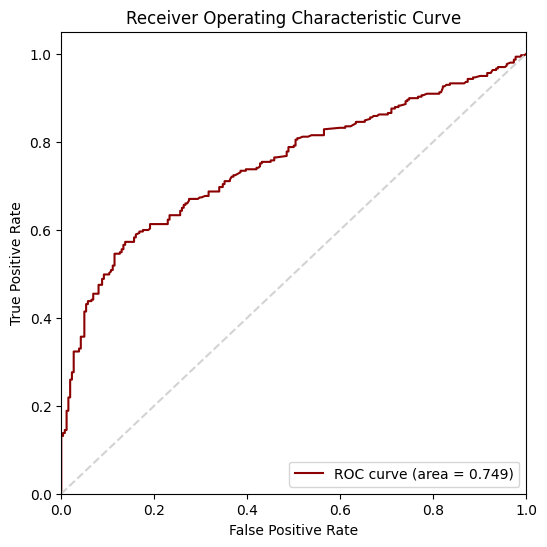

0.7048300536672629


In [8]:
roc_auc, test_accuracy, clf = edge_prediction(train_set_final)

print(test_accuracy)

In [5]:
test_features = test_set_final[['cosine_similarity', 'common_neighbors', 'degree_source', 'degree_target','jaccard']].values
test_preds_values = clf.predict(test_features)
test_preds_values = zip(np.array(range(len(test_set_final))), test_preds_values)
test_preds_values

In [6]:
with open("../submission/Log_Reg/LR_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in test_preds_values:
         csv_out.writerow(row)
    pred.close()